<a href="https://colab.research.google.com/github/amyxjhuang/nst-painter/blob/main/nst_painter.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Using 19-layer VGG Network, to extract style from the image

Sources:
* https://www.kaggle.com/code/just4jcgeorge/styletransfer-using-vgg19-pytorch

In [ ]:
import torch
import torchvision.transforms as transforms
from PIL import Image
import torchvision.models as models


In [ ]:
from google.colab import drive
import os
drive.mount('/content/drive', force_remount=True)

# image = Image.open("your_image.jpg")  # Load image
folder_path = "/content/drive/My Drive/NST Painter/images/"
image_files = [os.path.join(folder_path, f) for f in os.listdir(folder_path) if f.endswith(('.png', '.jpg', '.jpeg'))]



Mounted at /content/drive


In [ ]:
print("Found images:", image_files)

Found images: ['/content/drive/My Drive/NST Painter/images/painting0.png', '/content/drive/My Drive/NST Painter/images/painting1.png', '/content/drive/My Drive/NST Painter/images/image1.png']


In [ ]:
std = [0.229, 0.224, 0.225]
mean = [0.485, 0.456, 0.406]

In [ ]:
import torch
import torchvision.transforms as transforms
from PIL import Image


# Define the transformation (resizing, converting to tensor, normalization)
transform = transforms.Compose([
    transforms.Resize((512, 512)),  # Resize to 512x512 pixels
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Load all images into a list of tensors
image_tensors = [transform(Image.open(img).convert("RGB")).unsqueeze(0) for img in image_files]

print(f"Loaded {len(image_tensors)} images as tensors.")

Loaded 3 images as tensors.


In [ ]:
import matplotlib.pyplot as plt

def show_image(tensor):
    image = tensor.cpu().clone().detach().squeeze(0)  # Remove batch dimension
    image = image * torch.tensor([0.229, 0.224, 0.225]).view(3, 1, 1) + torch.tensor([0.485, 0.456, 0.406]).view(3, 1, 1)  # Unnormalize
    image = image.clamp(0, 1)  # Clamp values between 0 and 1
    plt.imshow(image.permute(1, 2, 0))  # Convert from CxHxW to HxWxC
    plt.axis("off")
    plt.show()



In [ ]:
import numpy as np
def load_image(image_path, max_size=512):
    image = Image.open(image_path).convert('RGB')  # Ensure it's in RGB format

    # Define image transformation pipeline
    transform = transforms.Compose([
        transforms.Resize((max_size, max_size)),  # Resize to a square
        transforms.ToTensor(),  # Convert to tensor
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Match VGG-19 input
    ])

    # Apply transformations
    image = transform(image).unsqueeze(0)  # Add batch dimension
    return image


def im_convert(tensor: torch.Tensor) -> np.ndarray:
    """Convert a PyTorch tensor to a NumPy image."""
    image = tensor.to("cpu").clone().detach().numpy().squeeze().transpose(1, 2, 0)  # Convert tensor to NumPy array
    image = image * np.array((0.229, 0.224, 0.225)) + np.array((0.485, 0.456, 0.406))  # Reverse normalization
    image = image.clip(0, 1)  # Clip values to the valid range [0, 1]
    return image

# content_image = load_image('content_image.png')
# style_image = load_image('style_image.png')


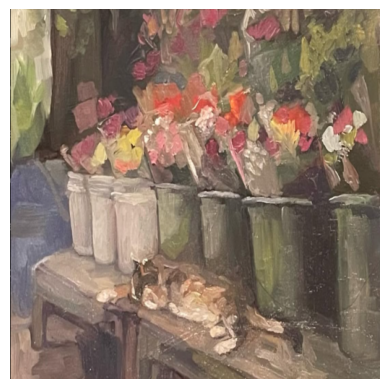

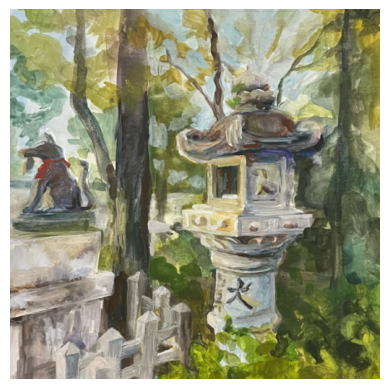

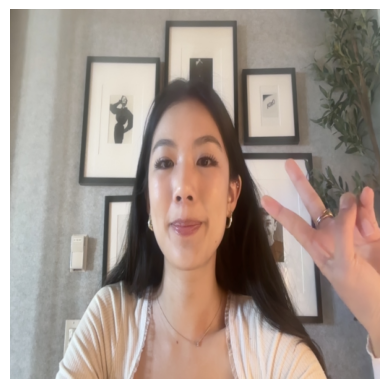

In [ ]:
for tensor in image_tensors:
  show_image(tensor)

In [ ]:
vgg = models.vgg19(pretrained=True).features

for param in vgg.parameters():
    param.requires_grad_(False)


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG19_Weights.IMAGENET1K_V1`. You can also use `weights=VGG19_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


If a GPU is available we will move the vgg model to that device.

In [ ]:
device = torch.device("cpu")

if torch.cuda.is_available():
    print("Using GPU")
    device = torch.device("cuda")

vgg.to(device)


Using GPU


Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU(inplace=True)
  (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (3): ReLU(inplace=True)
  (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (6): ReLU(inplace=True)
  (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (8): ReLU(inplace=True)
  (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): ReLU(inplace=True)
  (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (13): ReLU(inplace=True)
  (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (15): ReLU(inplace=True)
  (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (17): ReLU(inplace=True)
  (18): MaxPoo

In [ ]:
def tensor_to_image(tensor):
    # Detach tensor from the computational graph in Pytorch
    image = tensor.clone().detach()

    # Convert the tensor to Numpy format
    # Squeeze function that we invoke on Numpy will get rid of the batch dimension
    # of size 1 dimensions
    # The squeeze function in general squeezes out all size 1 dimensions

    image = image.cpu().numpy().squeeze()

    # The tensor representation of our image has channels in the first dimensions
    # then height and width of the image. We need to perform a transpose operation
    # so that we get the image in the format where the dimensions are first height
    # then width and then the number of channels
    # This is what matplotlib expects
    image = image.transpose(1, 2, 0)

    # Multiply pixel values by std deviation and add the mean
    # so that we normalize the image.
    image *= np.array(std) + np.array(mean)

    # Clip all pixel values in the range 0 to 1 and return this image
    image = image.clip(0, 1)

    return image


In [ ]:
content_image = image_tensors[2]
style_image = image_tensors[1]

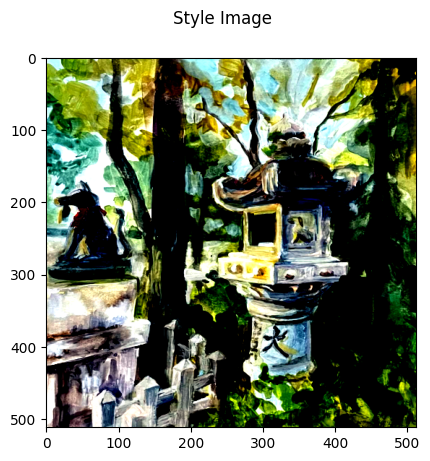

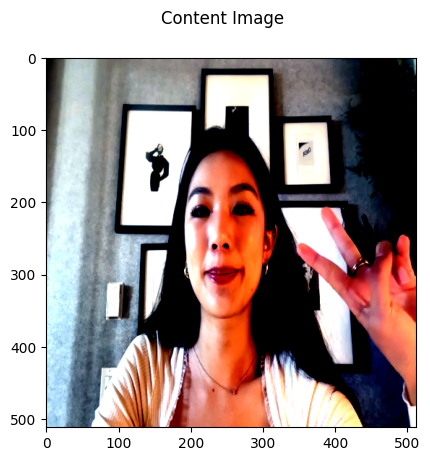

In [ ]:
img = tensor_to_image(style_image)
fig = plt.figure()
fig.suptitle('Style Image')
plt.imshow(img)

img = tensor_to_image(content_image)
fig = plt.figure()
fig.suptitle('Content Image')
plt.imshow(img)


In [ ]:
LAYERS_OF_INTEREST = {'0': 'conv1_1',
                      '5': 'conv2_1',
                      '10': 'conv3_1',
                      '19': 'conv4_1',
                      '21': 'conv4_2',
                      '28': 'conv5_1'}

def apply_model_and_extract_features(image, model):
    x = image

    features = {}

    for name, layer in model._modules.items():
        x = layer(x)

        if name in LAYERS_OF_INTEREST:
            features[LAYERS_OF_INTEREST[name]] = x

    return features


In [ ]:
content_image = content_image.to(device)
style_image = style_image.to(device)

content_img_features = apply_model_and_extract_features(content_image, vgg)
style_img_features   = apply_model_and_extract_features(style_image, vgg)


In [ ]:
def transformation(img):

    tasks = tf.Compose([tf.Resize(256),
                        tf.ToTensor(),
                        tf.Normalize(mean, std)])

    img = tasks(img)
    img = img.unsqueeze(0)

    return img



In [ ]:
def calculate_gram_matrix(tensor):

    _, channels, height, width = tensor.size()

    tensor = tensor.view(channels, height * width)

    gram_matrix = torch.mm(tensor, tensor.t())

    gram_matrix = gram_matrix.div(channels * height * width)

    return gram_matrix


In [ ]:
style_features_gram_matrix = {layer: calculate_gram_matrix(style_img_features[layer]) for layer in
                                                    style_img_features}

style_features_gram_matrix


{'conv1_1': tensor([[2.6096e-03, 1.5942e-03, 1.1244e-03,  ..., 4.0195e-04, 7.2096e-04,
          1.5955e-03],
         [1.5942e-03, 1.1541e-02, 4.1884e-04,  ..., 3.3297e-04, 1.8885e-03,
          3.6274e-03],
         [1.1244e-03, 4.1884e-04, 7.8657e-04,  ..., 8.6011e-05, 2.9158e-04,
          7.2972e-04],
         ...,
         [4.0195e-04, 3.3297e-04, 8.6011e-05,  ..., 5.2406e-04, 3.9388e-04,
          4.8073e-04],
         [7.2096e-04, 1.8885e-03, 2.9158e-04,  ..., 3.9388e-04, 2.2644e-03,
          1.9094e-03],
         [1.5955e-03, 3.6274e-03, 7.2972e-04,  ..., 4.8073e-04, 1.9094e-03,
          4.1178e-03]], device='cuda:0'),
 'conv2_1': tensor([[0.0158, 0.0013, 0.0091,  ..., 0.0031, 0.0015, 0.0045],
         [0.0013, 0.0069, 0.0028,  ..., 0.0026, 0.0015, 0.0019],
         [0.0091, 0.0028, 0.0217,  ..., 0.0039, 0.0017, 0.0064],
         ...,
         [0.0031, 0.0026, 0.0039,  ..., 0.0085, 0.0015, 0.0028],
         [0.0015, 0.0015, 0.0017,  ..., 0.0015, 0.0106, 0.0051],
         [0.

In [ ]:
import torch
import torch.optim as optim

weights = {'conv1_1': 1.0, 'conv2_1': 0.75, 'conv3_1': 0.35,
           'conv4_1': 0.25, 'conv5_1': 0.15}
target = torch.nn.Parameter(content_image.clone().to(device))

optimizer = optim.Adam([target], lr=0.003)


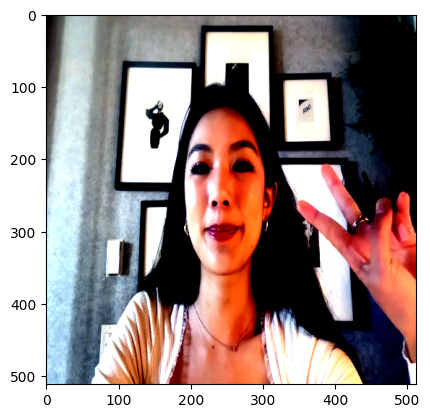

In [ ]:
plt.figure()

plt.imshow(tensor_to_image(target))


In [ ]:

from torchvision import transforms as tf
import torch.nn.functional as F


for i in range(1, 2000):

    target_features = apply_model_and_extract_features(target, vgg)

    content_loss = F.mse_loss (target_features['conv4_2'], content_img_features['conv4_2'])

    style_loss = 0
    for layer in weights:

        target_feature = target_features[layer]

        target_gram_matrix = calculate_gram_matrix(target_feature)
        style_gram_matrix = style_features_gram_matrix[layer]

        layer_loss = F.mse_loss (target_gram_matrix, style_gram_matrix)
        layer_loss *= weights[layer]

        _, channels, height, width = target_feature.shape

        style_loss += layer_loss

    total_loss = 1000000 * style_loss + content_loss

    if i % 50 == 0:
        print ('Epoch {}:, Style Loss : {:4f}, Content Loss : {:4f}'.format( i, style_loss, content_loss))

    optimizer.zero_grad()

    total_loss.backward()

    optimizer.step()

Epoch 50:, Style Loss : 0.000004, Content Loss : 1.089291
Epoch 100:, Style Loss : 0.000002, Content Loss : 0.930340
Epoch 150:, Style Loss : 0.000002, Content Loss : 0.848642
Epoch 200:, Style Loss : 0.000001, Content Loss : 0.797903
Epoch 250:, Style Loss : 0.000001, Content Loss : 0.763066
Epoch 300:, Style Loss : 0.000001, Content Loss : 0.736921
Epoch 350:, Style Loss : 0.000001, Content Loss : 0.716518
Epoch 400:, Style Loss : 0.000001, Content Loss : 0.699893
Epoch 450:, Style Loss : 0.000001, Content Loss : 0.685207
Epoch 500:, Style Loss : 0.000001, Content Loss : 0.672957
Epoch 550:, Style Loss : 0.000001, Content Loss : 0.662380
Epoch 600:, Style Loss : 0.000001, Content Loss : 0.653253
Epoch 650:, Style Loss : 0.000001, Content Loss : 0.644758
Epoch 700:, Style Loss : 0.000001, Content Loss : 0.637257
Epoch 750:, Style Loss : 0.000001, Content Loss : 0.630616
Epoch 800:, Style Loss : 0.000001, Content Loss : 0.624469
Epoch 850:, Style Loss : 0.000001, Content Loss : 0.61881

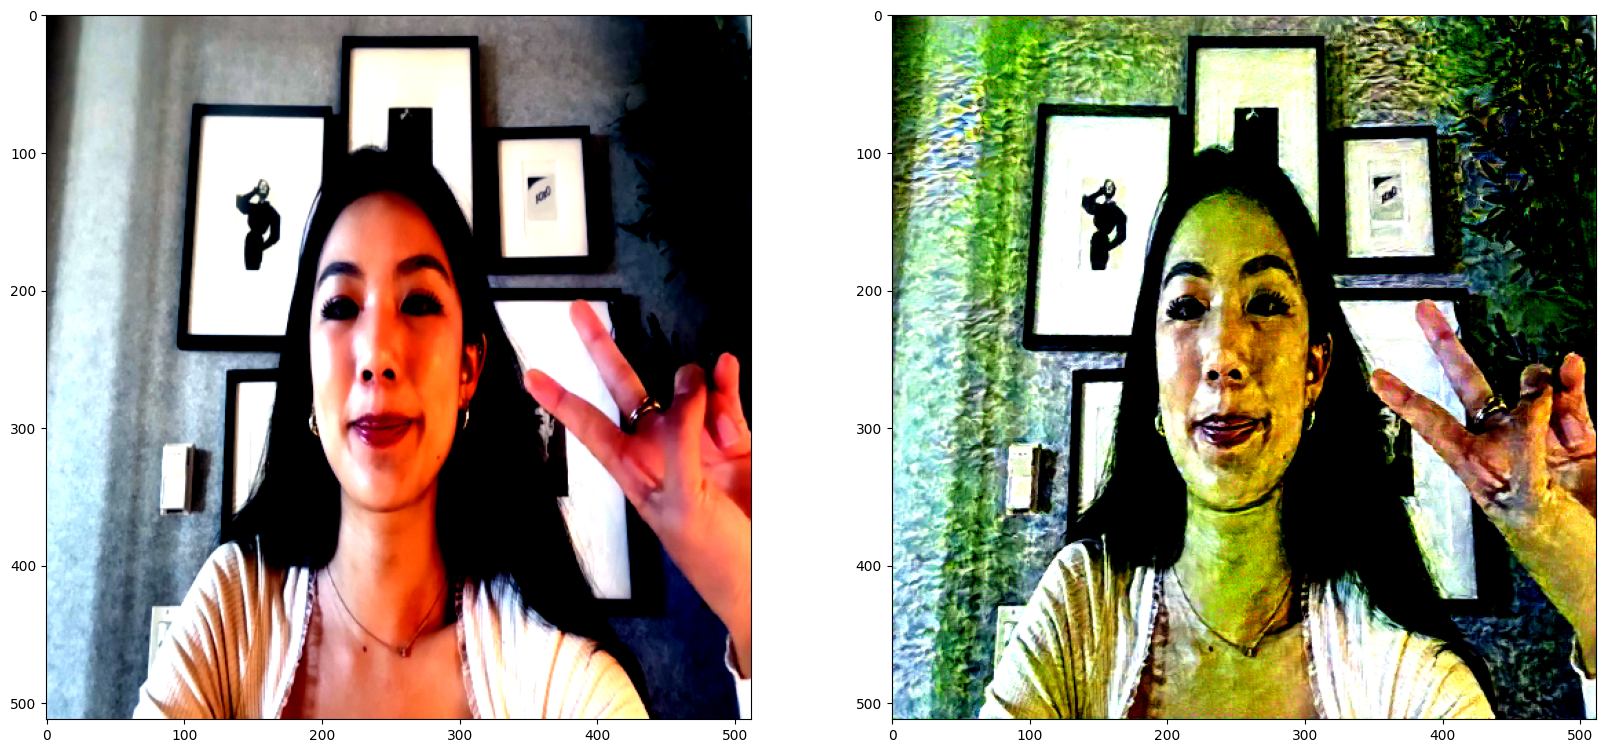

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))
ax1.imshow(tensor_to_image(content_image))
ax2.imshow(tensor_to_image(target))

In [ ]:
def apply_style_on_image(image):
    tensor_image = transform(Image.open(img).convert("RGB")).unsqueeze(0)
